In [1]:

import sys
import os
import pandas as pd
import numpy as np

sys.path.append(os.path.abspath('../scripts'))


from telecom_analysis import load_data_using_sqlalchemy


# Define your SQL query
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load data from PostgreSQL using SQLAlchemy
df_user_engagement = load_data_using_sqlalchemy(query)

# Display the first few rows of the dataframe
if df_user_engagement is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")
    
    
    
# Group by MSISDN to aggregate per customer
user_engagement = df_user_engagement.groupby('MSISDN/Number').agg({
    'Dur. (ms)': 'sum',  # Session duration
    'HTTP DL (Bytes)': 'sum',  # Download bytes
    'HTTP UL (Bytes)': 'sum',  # Upload bytes
    'Bearer Id': 'count'  # Session frequency
}).rename(columns={'Dur. (ms)': 'total_session_duration', 
                   'HTTP DL (Bytes)': 'total_download',
                   'HTTP UL (Bytes)': 'total_upload',
                   'Bearer Id': 'session_frequency'})

# Calculate total traffic (download + upload)
user_engagement['total_traffic'] = user_engagement['total_download'] + user_engagement['total_upload']

# Display the top 10 customers per engagement metric
print(user_engagement.sort_values('session_frequency', ascending=False).head(10))  # Top 10 by session frequency
print(user_engagement.sort_values('total_session_duration', ascending=False).head(10))  # Top 10 by session duration
print(user_engagement.sort_values('total_traffic', ascending=False).head(10))  # Top 10 by total traffic

df_user_engagement


from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize the metrics
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(user_engagement[['session_frequency', 'total_session_duration', 'total_traffic']])

# Apply K-Means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
user_engagement['engagement_cluster'] = kmeans.fit_predict(normalized_metrics)

# Add cluster labels to the user_engagement dataframe
user_engagement['cluster'] = kmeans.labels_

# Visualize the clusters
sns.pairplot(user_engagement, vars=['session_frequency', 'total_session_duration', 'total_traffic'], hue='cluster', palette='Set2')
plt.title('K-Means Clustering of User Engagement')
plt.show()


# Group by cluster and calculate summary statistics for each cluster
cluster_summary = user_engagement.groupby('cluster').agg({
    'session_frequency': ['min', 'max', 'mean', 'sum'],
    'total_session_duration': ['min', 'max', 'mean', 'sum'],
    'total_traffic': ['min', 'max', 'mean', 'sum']
})

print("Cluster Summary Statistics:\n", cluster_summary)



import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check the columns in the DataFrame

# Compute minimum, maximum, average, and total metrics for each cluster
if 'cluster' in df_user_engagement.columns:  # Replace 'cluster' with your actual clustering column if needed
    cluster_metrics = df_user_engagement.groupby('cluster').agg({
        'Social Media DL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Social Media UL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Google DL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Google UL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Email DL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Email UL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Youtube DL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Youtube UL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Netflix DL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Netflix UL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Gaming DL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Gaming UL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Other DL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Other UL (Bytes)': ['min', 'max', 'mean', 'sum']
    })
    print("Cluster Metrics:")
    print(cluster_metrics)
else:
    print("Cluster column not found in DataFrame. Please check column names.")

# Aggregate user total traffic per application
applications = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']
user_engagement = pd.DataFrame()

for app in applications:
    app_dl = f'{app} DL (Bytes)'
    app_ul = f'{app} UL (Bytes)'
    
    if app_dl in df_user_engagement.columns and app_ul in df_user_engagement.columns:
        user_engagement[f'{app}_total_traffic'] = df_user_engagement.groupby('MSISDN/Number')[[app_dl, app_ul]].sum().sum(axis=1)
        
        # Top 10 users per application by traffic
        top_users = user_engagement[[f'{app}_total_traffic']].sort_values(f'{app}_total_traffic', ascending=False).head(10)
        print(f"Top 10 users by {app} traffic:")
        print(top_users)
    else:
        print(f"Columns for {app} not found in DataFrame.")

# Plotting the top 3 most used applications
# Calculate total traffic for each application
total_traffic = {app: user_engagement[f'{app}_total_traffic'].sum() for app in applications if f'{app}_total_traffic' in user_engagement.columns}
top_3_apps = sorted(total_traffic.items(), key=lambda x: x[1], reverse=True)[:3]

# Create a DataFrame for plotting
top_3_df = pd.DataFrame(top_3_apps, columns=['Application', 'Total Traffic'])

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(y='Total Traffic', x='Application', data=top_3_df, palette='viridis')
plt.title('Top 3 Most Used Applications')
plt.xlabel('Total Traffic (Bytes)')
plt.ylabel('Application')
plt.show()

# Aggregating total traffic per application and identifying the top 10 users
applications = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']
for app in applications:
    app_dl = f'{app} DL (Bytes)'
    app_ul = f'{app} UL (Bytes)'
    
    user_engagement[f'{app}_total_traffic'] = df_user_engagement.groupby('MSISDN/Number')[[app_dl, app_ul]].sum().sum(axis=1)
    
    # Top 10 users per application by traffic
    print(f"Top 10 users by {app} traffic:")
    print(user_engagement[[f'{app}_total_traffic']].sort_values(f'{app}_total_traffic', ascending=False).head(10))

# Plotting for one application (e.g., Social Media)
top_users_social_media = user_engagement[['Social Media_total_traffic']].sort_values('Social Media_total_traffic', ascending=False).head(10)
top_users_social_media.plot(kind='barh', figsize=(10, 6), title="Top 10 Users by Social Media Traffic")
plt.show()
# Verify and correct the column name
corrected_column_name = 'MSISDN/Number'  # Make sure this matches exactly with the DataFrame column name

# List of applications
applications = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']

# Initialize an empty DataFrame for user engagement
user_engagement = pd.DataFrame()

for app in applications:
    app_dl = f'{app} DL (Bytes)'
    app_ul = f'{app} UL (Bytes)'

    # Ensure columns exist in the DataFrame
    if app_dl in df_user_engagement.columns and app_ul in df_user_engagement.columns:
        # Aggregating total traffic per application
        user_engagement[f'{app}_total_traffic'] = df_user_engagement.groupby(corrected_column_name)[[app_dl, app_ul]].sum().sum(axis=1)
        
        # Top 10 users per application by traffic
        print(f"Top 10 users by {app} traffic:")
        print(user_engagement[[f'{app}_total_traffic']].sort_values(f'{app}_total_traffic', ascending=False).head(10))
    else:
        print(f"Columns {app_dl} and/or {app_ul} do not exist in the DataFrame.")
        import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load your data
# df_user_engagement = pd.read_csv('path_to_your_data.csv')  # Uncomment and adjust as necessary

# Sample DataFrame for demonstration purposes
# Replace this with your actual DataFrame loading code
data = {
    'MSISDN/Number': ['user1', 'user2', 'user3', 'user4', 'user5'],
    'Social Media DL (Bytes)': [1000, 1500, 2000, 1200, 1800],
    'Social Media UL (Bytes)': [500, 600, 700, 550, 650],
    'Google DL (Bytes)': [2000, 2500, 3000, 2200, 2700],
    'Google UL (Bytes)': [1000, 1200, 1400, 1100, 1300],
    'Email DL (Bytes)': [1500, 1600, 1700, 1400, 1550],
    'Email UL (Bytes)': [600, 650, 700, 550, 600],
    'Youtube DL (Bytes)': [2500, 3000, 3500, 2700, 3200],
    'Youtube UL (Bytes)': [1200, 1300, 1400, 1150, 1250],
    'Netflix DL (Bytes)': [3000, 3500, 4000, 3200, 3700],
    'Netflix UL (Bytes)': [1400, 1500, 1600, 1300, 1450],
    'Gaming DL (Bytes)': [2000, 2200, 2400, 2100, 2300],
    'Gaming UL (Bytes)': [800, 850, 900, 750, 850],
    'Other DL (Bytes)': [500, 600, 700, 550, 650],
    'Other UL (Bytes)': [200, 250, 300, 180, 220],
}

df_user_engagement = pd.DataFrame(data)

# Aggregate metrics per customer ID (MSISDN)
aggregated_metrics = df_user_engagement.groupby('MSISDN/Number').agg({
    'Social Media DL (Bytes)': 'sum',
    'Social Media UL (Bytes)': 'sum',
    'Google DL (Bytes)': 'sum',
    'Google UL (Bytes)': 'sum',
    'Email DL (Bytes)': 'sum',
    'Email UL (Bytes)': 'sum',
    'Youtube DL (Bytes)': 'sum',
    'Youtube UL (Bytes)': 'sum',
    'Netflix DL (Bytes)': 'sum',
    'Netflix UL (Bytes)': 'sum',
    'Gaming DL (Bytes)': 'sum',
    'Gaming UL (Bytes)': 'sum',
    'Other DL (Bytes)': 'sum',
    'Other UL (Bytes)': 'sum',
})

# Normalize the metrics
scaler = StandardScaler()
normalized_metrics = scaler.fit_transform(aggregated_metrics)

# Determine optimal k using the Elbow Method
inertia = []
k_range = range(1, min(len(aggregated_metrics), 11))  # Ensure k does not exceed number of samples

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_metrics)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Based on the elbow plot, choose the optimal k (usually where the curve starts to flatten)
optimal_k = 3  # Replace with the value you determine from the elbow plot

# Fit k-means with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_user_engagement['cluster'] = kmeans.fit_predict(normalized_metrics)

# Compute min, max, average, and total non-normalized metrics for each cluster
cluster_metrics = df_user_engagement.groupby('cluster').agg({
    'Social Media DL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Social Media UL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Google DL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Google UL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Email DL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Email UL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Youtube DL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Youtube UL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Netflix DL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Netflix UL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Gaming DL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Gaming UL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Other DL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Other UL (Bytes)': ['min', 'max', 'mean', 'sum']
})

print("Cluster Metrics:")
print(cluster_metrics)




Successfully loaded the data


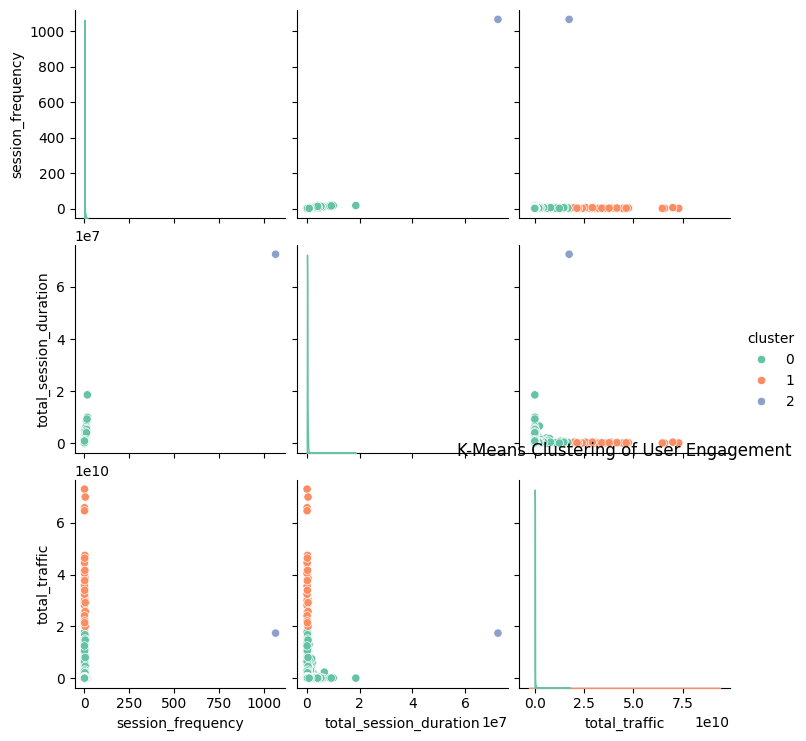

Cluster Summary Statistics:
         session_frequency                            total_session_duration  \
                      min   max         mean     sum                    min   
cluster                                                                       
0                       1    18     1.393469  148849                 7142.0   
1                       1     6     2.324324      86                56123.0   
2                    1066  1066  1066.000000    1066             72446396.0   

                                                total_traffic                \
                max          mean           sum           min           max   
cluster                                                                       
0        18553754.0  1.461471e+05  1.561128e+10  0.000000e+00  1.775945e+10   
1          513104.0  2.041768e+05  7.554541e+06  1.808859e+10  7.302069e+10   
2        72446396.0  7.244640e+07  7.244640e+07  1.739805e+10  1.739805e+10   

                     

C:\Users\Yonas\AppData\Local\Temp\ipykernel_2088\2008698929.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Total Traffic', x='Application', data=top_3_df, palette='viridis')


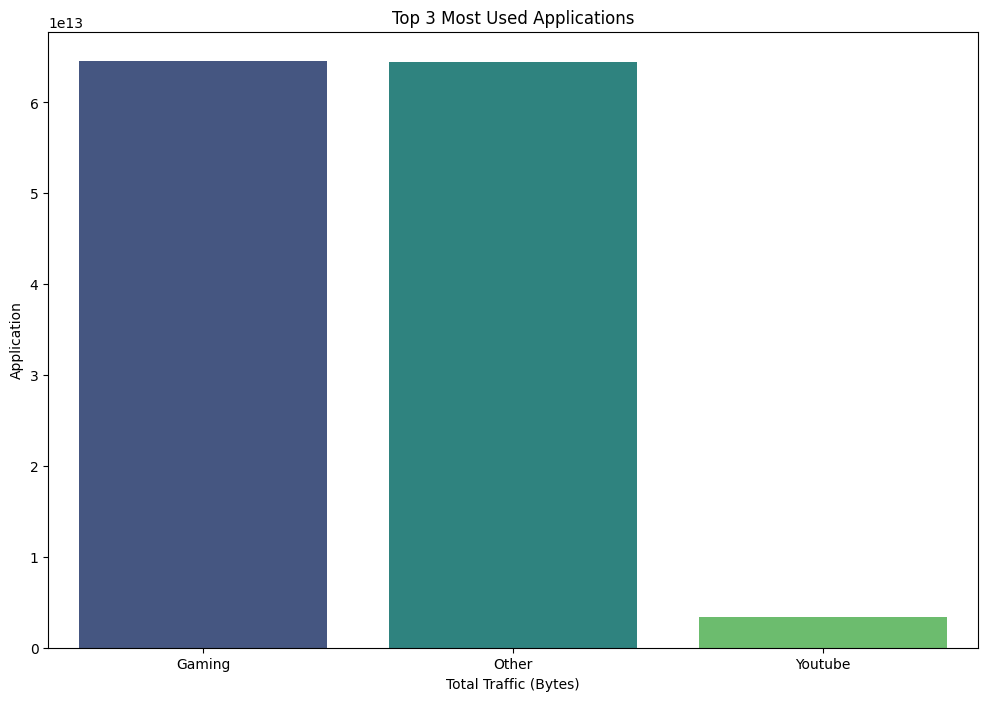

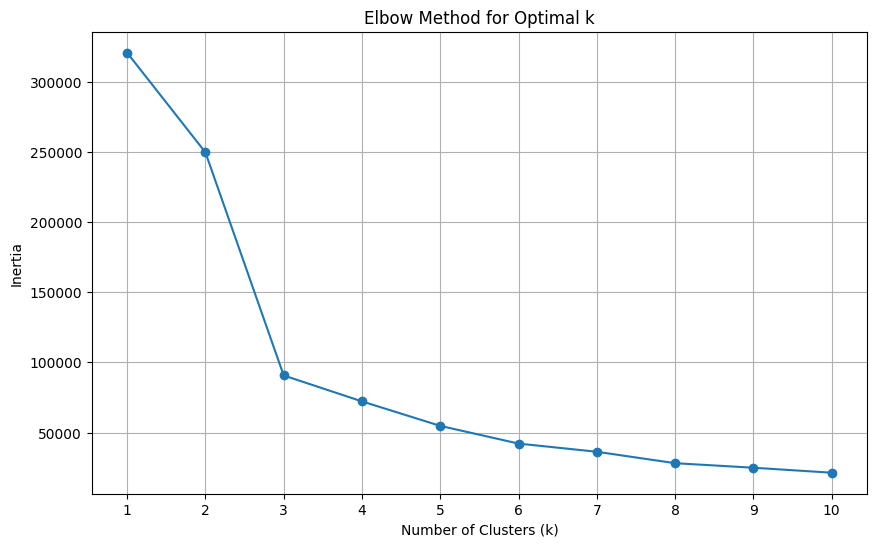

Cluster Metrics:
         session_frequency                            total_session_duration  \
                      min   max         mean     sum                    min   
cluster                                                                       
0                       1    18     1.393469  148849                 7142.0   
1                       1     6     2.324324      86                56123.0   
2                    1066  1066  1066.000000    1066             72446396.0   

                                                total_traffic                \
                max          mean           sum           min           max   
cluster                                                                       
0        18553754.0  1.461471e+05  1.561128e+10  0.000000e+00  1.775945e+10   
1          513104.0  2.041768e+05  7.554541e+06  1.808859e+10  7.302069e+10   
2        72446396.0  7.244640e+07  7.244640e+07  1.739805e+10  1.739805e+10   

                                

In [3]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sys.path.append(os.path.abspath('../scripts'))

from telecom_analysis import load_data_using_sqlalchemy

# Define your SQL query
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load data from PostgreSQL using SQLAlchemy
df_user_engagement = load_data_using_sqlalchemy(query)

# Check if data loaded successfully
if df_user_engagement is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")
    sys.exit()

# Task 2.1 - Aggregate metrics per customer ID (MSISDN)
user_engagement = df_user_engagement.groupby('MSISDN/Number').agg({
    'Dur. (ms)': 'sum',  # Session duration
    'HTTP DL (Bytes)': 'sum',  # Download bytes
    'HTTP UL (Bytes)': 'sum',  # Upload bytes
    'Bearer Id': 'count'  # Session frequency
}).rename(columns={
    'Dur. (ms)': 'total_session_duration',
    'HTTP DL (Bytes)': 'total_download',
    'HTTP UL (Bytes)': 'total_upload',
    'Bearer Id': 'session_frequency'
})

# Reset index to include 'MSISDN/Number' as a column
user_engagement = user_engagement.reset_index()

# Calculate total traffic (download + upload)
user_engagement['total_traffic'] = user_engagement['total_download'] + user_engagement['total_upload']

# Normalize the metrics
scaler = StandardScaler()
normalized_metrics = scaler.fit_transform(user_engagement[['session_frequency', 'total_session_duration', 'total_traffic']])

# Apply K-Means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
user_engagement['cluster'] = kmeans.fit_predict(normalized_metrics)

# Assign the MSISDN/Number column to the engagement_cluster column
user_engagement['engagement_cluster'] = user_engagement['MSISDN/Number']

# Visualize the clusters
sns.pairplot(user_engagement, vars=['session_frequency', 'total_session_duration', 'total_traffic'], hue='cluster', palette='Set2')
plt.title('K-Means Clustering of User Engagement')
plt.show()


# Group by cluster and calculate summary statistics for each cluster
cluster_summary = user_engagement.groupby('cluster').agg({
    'session_frequency': ['min', 'max', 'mean', 'sum'],
    'total_session_duration': ['min', 'max', 'mean', 'sum'],
    'total_traffic': ['min', 'max', 'mean', 'sum']
})

print("Cluster Summary Statistics:\n", cluster_summary)

# Aggregate user total traffic per application
applications = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']
user_engagement_apps = pd.DataFrame()

for app in applications:
    app_dl = f'{app} DL (Bytes)'
    app_ul = f'{app} UL (Bytes)'
    
    if app_dl in df_user_engagement.columns and app_ul in df_user_engagement.columns:
        user_engagement_apps[f'{app}_total_traffic'] = df_user_engagement.groupby('MSISDN/Number')[[app_dl, app_ul]].sum().sum(axis=1)
        
        # Top 10 users per application by traffic
        top_users = user_engagement_apps[[f'{app}_total_traffic']].sort_values(f'{app}_total_traffic', ascending=False).head(10)
        print(f"\nTop 10 users by {app} traffic:")
        print(top_users)
    else:
        print(f"Columns for {app} not found in DataFrame.")

# Plot the top 3 most used applications
total_traffic = {app: user_engagement_apps[f'{app}_total_traffic'].sum() for app in applications if f'{app}_total_traffic' in user_engagement_apps.columns}
top_3_apps = sorted(total_traffic.items(), key=lambda x: x[1], reverse=True)[:3]

# Create a DataFrame for plotting
top_3_df = pd.DataFrame(top_3_apps, columns=['Application', 'Total Traffic'])

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(y='Total Traffic', x='Application', data=top_3_df, palette='viridis')
plt.title('Top 3 Most Used Applications')
plt.xlabel('Total Traffic (Bytes)')
plt.ylabel('Application')
plt.show()

# Determine optimal k using the Elbow Method
inertia = []
k_range = range(1, min(len(user_engagement_apps), 11))  # Ensure k does not exceed number of samples

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_metrics)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Based on the elbow plot, choose the optimal k (usually where the curve starts to flatten)
optimal_k = 3  # Replace with the value you determine from the elbow plot

# Fit k-means with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_engagement['cluster'] = kmeans.fit_predict(normalized_metrics)

# Compute min, max, average, and total non-normalized metrics for each cluster
cluster_metrics = user_engagement.groupby('cluster').agg({
    'session_frequency': ['min', 'max', 'mean', 'sum'],
    'total_session_duration': ['min', 'max', 'mean', 'sum'],
    'total_traffic': ['min', 'max', 'mean', 'sum']
})

print("Cluster Metrics:\n", cluster_metrics)


In [5]:
print (user_engagement.columns)

Index(['MSISDN/Number', 'total_session_duration', 'total_download',
       'total_upload', 'session_frequency', 'total_traffic', 'cluster',
       'engagement_cluster'],
      dtype='object')


Successfully loaded the data

Top 10 TCP Retransmission Values:
5705      4.294426e+09
63404     4.291380e+09
112372    4.289877e+09
68539     4.289488e+09
81509     4.288060e+09
47410     4.275259e+09
117364    4.268432e+09
4716      4.259997e+09
136743    4.256650e+09
118936    4.254644e+09
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Bottom 10 TCP Retransmission Values:
0     0.0
1     0.0
3     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
11    0.0
12    0.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Most Frequent TCP Retransmission Values:
0    0.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Top 10 RTT Values:
107893    96923.0
107654    64640.0
95637     55811.0
83716     54847.0
100578    26971.0
101182    26250.0
79100     25873.0
9000      25602.0
25047     25374.0
28310     24733.0
Name: Avg RTT DL (ms), dtype: float64

Bottom 10 RTT Values:
1     0.0
6     0.0
12    0.0
14    0.0
17    0.0
18    0.0
27    0.0
33    0.0
46    0.0
61    0.0
Name: 

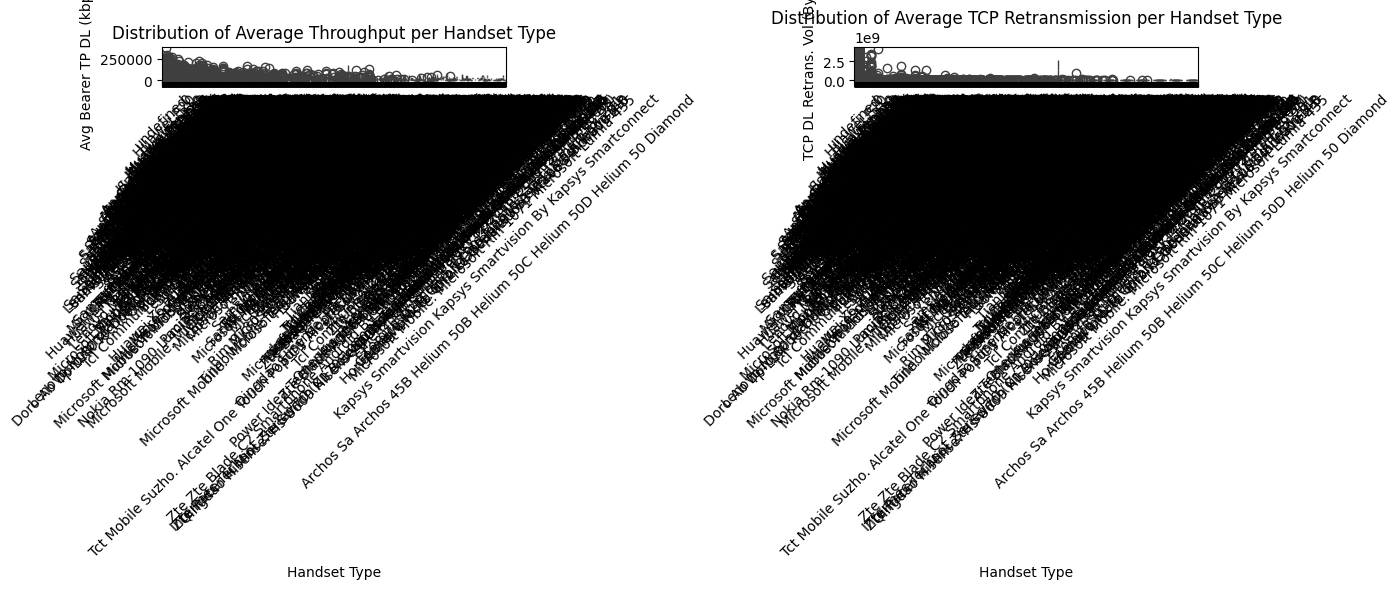

Aggregated Data by Handset Type:
                                           Handset Type  \
0                                                     0   
1                            A-Link Telecom I. Cubot A5   
2                     A-Link Telecom I. Cubot Note Plus   
3                        A-Link Telecom I. Cubot Note S   
4                          A-Link Telecom I. Cubot Nova   
...                                                 ...   
1392  Zte Zte Blade C2 Smartphone Android By Sfr Sta...   
1393                          Zyxel Communicat. Lte7460   
1394                          Zyxel Communicat. Sbg3600   
1395                    Zyxel Communicat. Zyxel Wah7706   
1396                                          undefined   

      Avg Bearer TP DL (kbps)  TCP DL Retrans. Vol (Bytes)  
0                10790.970280                 1.146738e+07  
1                23184.000000                 0.000000e+00  
2                 6527.000000                 6.023490e+05  
3             

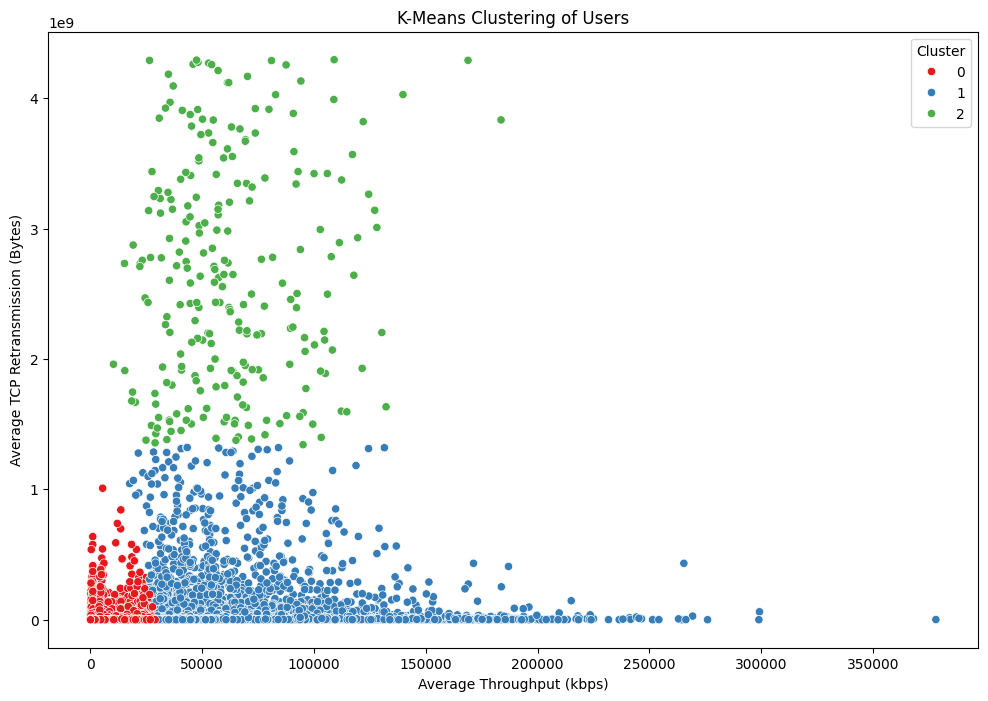

In [9]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Append the script directory to sys.path
sys.path.append(os.path.abspath('../scripts'))

from telecom_analysis import load_data_using_sqlalchemy

# Load data from PostgreSQL
query = "SELECT * FROM xdr_data;"  # Adjust as needed
df = load_data_using_sqlalchemy(query)

if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

# Task 3.1 - Aggregate per customer
def clean_and_aggregate(df):
    df.fillna({
        'TCP DL Retrans. Vol (Bytes)': df['TCP DL Retrans. Vol (Bytes)'].mean(),
        'Avg RTT DL (ms)': df['Avg RTT DL (ms)'].mean(),
        'Avg Bearer TP DL (kbps)': df['Avg Bearer TP DL (kbps)'].mean(),
        'Handset Type': df['Handset Type'].mode()[0]  # Fill missing Handset Type with mode
    }, inplace=True)
    
    # Replace infinities with NaN and fill again
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna({
        'TCP DL Retrans. Vol (Bytes)': df['TCP DL Retrans. Vol (Bytes)'].mean(),
        'Avg RTT DL (ms)': df['Avg RTT DL (ms)'].mean(),
        'Avg Bearer TP DL (kbps)': df['Avg Bearer TP DL (kbps)'].mean()
    }, inplace=True)
    
    # Aggregate data per customer
    aggregated = df.groupby('MSISDN/Number').agg({
        'TCP DL Retrans. Vol (Bytes)': 'mean',
        'Avg RTT DL (ms)': 'mean',
        'Avg Bearer TP DL (kbps)': 'mean',
        'Handset Type': 'first'  # Assuming handset type doesn't change per user
    }).reset_index()

    return aggregated

aggregated_df = clean_and_aggregate(df)

# Task 3.2 - Compute & list top, bottom, and most frequent values
def compute_statistics(df):
    # Top 10 values
    top_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nlargest(10)
    bottom_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nsmallest(10)
    frequent_tcp = df['TCP DL Retrans. Vol (Bytes)'].mode()
    
    top_10_rtt = df['Avg RTT DL (ms)'].nlargest(10)
    bottom_10_rtt = df['Avg RTT DL (ms)'].nsmallest(10)
    frequent_rtt = df['Avg RTT DL (ms)'].mode()
    
    top_10_throughput = df['Avg Bearer TP DL (kbps)'].nlargest(10)
    bottom_10_throughput = df['Avg Bearer TP DL (kbps)'].nsmallest(10)
    frequent_throughput = df['Avg Bearer TP DL (kbps)'].mode()
    
    # Print or return statistics
    print("\nTop 10 TCP Retransmission Values:")
    print(top_10_tcp)
    
    print("\nBottom 10 TCP Retransmission Values:")
    print(bottom_10_tcp)
    
    print("\nMost Frequent TCP Retransmission Values:")
    print(frequent_tcp)
    
    print("\nTop 10 RTT Values:")
    print(top_10_rtt)
    
    print("\nBottom 10 RTT Values:")
    print(bottom_10_rtt)
    
    print("\nMost Frequent RTT Values:")
    print(frequent_rtt)
    
    print("\nTop 10 Throughput Values:")
    print(top_10_throughput)
    
    print("\nBottom 10 Throughput Values:")
    print(bottom_10_throughput)
    
    print("\nMost Frequent Throughput Values:")
    print(frequent_throughput)
    
    return {
        'top_10_tcp': top_10_tcp,
        'bottom_10_tcp': bottom_10_tcp,
        'frequ  ent_tcp': frequent_tcp,
        'top_10_rtt': top_10_rtt,
        'bottom_10_rtt': bottom_10_rtt,
        'frequent_rtt': frequent_rtt,
        'top_10_throughput': top_10_throughput,
        'bottom_10_throughput': bottom_10_throughput,
        'frequent_throughput': frequent_throughput
    }
stats_summary = compute_statistics(df)

# Task 3.3 - Distribution of average throughput and TCP retransmission
def compute_and_plot_distributions(df):
    # Aggregate data by handset type
    aggregated_data = df.groupby('Handset Type').agg({
        'Avg Bearer TP DL (kbps)': 'mean',
        'TCP DL Retrans. Vol (Bytes)': 'mean'
    }).reset_index()
    
    # Distribution of average throughput per handset type
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='Handset Type', y='Avg Bearer TP DL (kbps)', data=df)
    plt.title('Distribution of Average Throughput per Handset Type')
    plt.xticks(rotation=45)

    # Distribution of average TCP retransmission per handset type
    plt.subplot(1, 2, 2)
    sns.boxplot(x='Handset Type', y='TCP DL Retrans. Vol (Bytes)', data=df)
    plt.title('Distribution of Average TCP Retransmission per Handset Type')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()
    
    # Print the aggregated data for interpretation
    print("Aggregated Data by Handset Type:")
    print(aggregated_data)

# Assuming df is your DataFrame
compute_and_plot_distributions(df)

# Task 3.4 - K-Means Clustering
#
def perform_kmeans_clustering(df, n_clusters=3):
    # Prepare the data for clustering
    features = df[['Avg Bearer TP DL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)']].copy()
    features.fillna(features.mean(), inplace=True)  # Handle missing values by replacing with the mean
    
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Apply k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    df['Cluster'] = kmeans.fit_predict(scaled_features)
    
    # Inverse transform the cluster centers to original scale
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
    cluster_centers_df = pd.DataFrame(cluster_centers, columns=['Avg Bearer TP DL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)'])
    
    # Display cluster centers
    print("Cluster Centers (Original Scale):")
    print(cluster_centers_df)
    
    return df

def describe_clusters(df):
    cluster_description = df.groupby('Cluster').agg({
        'Avg Bearer TP DL (kbps)': ['mean', 'std'],
        'TCP DL Retrans. Vol (Bytes)': ['mean', 'std'],
        'Avg RTT DL (ms)': ['mean', 'std'],
        'MSISDN/Number': 'count'
    }).reset_index()
    
    print("\nCluster Descriptions:")
    print(cluster_description)

    # Plot the clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='Avg Bearer TP DL (kbps)', y='TCP DL Retrans. Vol (Bytes)', hue='Cluster', data=df, palette='Set1')
    plt.title('K-Means Clustering of Users')
    plt.xlabel('Average Throughput (kbps)')
    plt.ylabel('Average TCP Retransmission (Bytes)')
    plt.legend(title='Cluster')
    plt.show()

# Assuming df is your DataFrame
clustered_df = perform_kmeans_clustering(df)
describe_clusters(clustered_df)


In [11]:
print (aggregated_df.columns)
print (user_engagement.columns)

Index(['MSISDN/Number', 'TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)',
       'Avg Bearer TP DL (kbps)', 'Handset Type'],
      dtype='object')
Index(['MSISDN/Number', 'total_session_duration', 'total_download',
       'total_upload', 'session_frequency', 'total_traffic', 'cluster',
       'engagement_cluster'],
      dtype='object')


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

def compute_scores(engagement_df, aggregated_df):
    # Ensure 'MSISDN/Number' column exists in both DataFrames


    # Data Cleaning: Drop rows with missing values in critical columns
    engagement_df.dropna(subset=['MSISDN/Number', 'session_frequency', 'total_session_duration', 'total_traffic'], inplace=True)
    aggregated_df.dropna(subset=['MSISDN/Number', 'TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)'], inplace=True)
    
    # Normalize the data
    scaler_engagement = StandardScaler()
    engagement_features = ['session_frequency', 'total_session_duration', 'total_traffic']
    engagement_normalized = scaler_engagement.fit_transform(engagement_df[engagement_features])
    
    scaler_experience = StandardScaler()
    experience_features = ['TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)']
    experience_normalized = scaler_experience.fit_transform(aggregated_df[experience_features])
    
    # Perform K-Means Clustering for engagement (assuming 3 clusters)
    kmeans_engagement = KMeans(n_clusters=3, random_state=42)
    engagement_df['engagement_cluster'] = kmeans_engagement.fit_predict(engagement_normalized)
    engagement_centers = kmeans_engagement.cluster_centers_

    # Perform K-Means Clustering for experience (assuming 3 clusters)
    kmeans_experience = KMeans(n_clusters=3, random_state=42)
    aggregated_df['experience_cluster'] = kmeans_experience.fit_predict(experience_normalized)
    experience_centers = kmeans_experience.cluster_centers_

    # Identify less engaged and worst experience clusters
    less_engaged_cluster = 2
    worst_experience_cluster = 2
    
    # Calculate engagement score as Euclidean distance from the less engaged cluster
    engagement_df['engagement_score'] = engagement_df.apply(
        lambda row: euclidean(
            scaler_engagement.transform([row[engagement_features]])[0],
            engagement_centers[less_engaged_cluster]
        ), axis=1
    )

    # Calculate experience score as Euclidean distance from the worst experience cluster
    aggregated_df['experience_score'] = aggregated_df.apply(
        lambda row: euclidean(
            scaler_experience.transform([row[experience_features]])[0],
            experience_centers[worst_experience_cluster]
        ), axis=1
    )

    # Merge scores with original data to maintain MSISDN/Number for identification
    scores_df = pd.merge(engagement_df[['MSISDN/Number', 'engagement_score']], aggregated_df[['MSISDN/Number', 'experience_score']], on='MSISDN/Number', how='inner')

    return scores_df

# Example usage
try:
    scores_df = compute_scores(user_engagement, aggregated_df)
    print(scores_df.head())
except KeyError as e:
    print(f"KeyError: {e}")
